In [1]:
import json
import matplotlib.pyplot as plt
from numpy import array, zeros
import scipy
from glob import glob
import os
import cv2
import numpy as np
import torch
import torchvision as vision
from torchvision import transforms
import joint_transforms
from torch.utils import data
from imageio import imread

In [2]:
## check PyTorch GPU support
print (torch.cuda.get_device_name(0))

GeForce GTX 1080 Ti


In [3]:
import training_utils

In [4]:
# IMG_PATH = '/media/data2TB/jeremyshi/data/cilia/train/data/'
# MASK_PATH = '/media/data2TB/jeremyshi/data/cilia/train/masks/'

def load_input(base, split):
    '''
    Helper function to get the foler path. Under base (could be train, val, or test). 
    Return the path for under the folders of training imgs and masks.
    '''
    input_imgs = []
    masks_imgs = []
    all_hash = sorted(os.listdir(base + split + '/data/'))

    for imgHash in all_hash:
        inputs = glob(base + split + '/data/' + imgHash + '/*.png')
        input_imgs.append(array([imread(f, pilmode='RGB') for f in inputs]).mean(axis=0))
#         input_imgs.append(array([imread(f) for f in inputs]))
        if split != 'test':
            masks = glob(base + split + '/masks/' + imgHash + '.png')
            masks_imgs.append(array([imread(f, pilmode='I') for f in masks]))
#         masks_imgs.append(array([imread(f) for f in masks]))
        
    # check whether if they are good
    if len(input_imgs) == 0 or len(masks_imgs) == 0:
        raise RuntimeError('Found 0 images, please check the data set')
    if len(input_imgs) != len(masks_imgs):
        raise RuntimeError('Must be the same amount of the input and mask images!')
        
    # reshape the input
    for i in range(len(input_imgs)):
# #         input_imgs[i] = input_imgs[i].reshape(input_imgs[i].shape + (1,))
        input_imgs[i] = input_imgs[i].astype(np.uint8)
    
    # reshape the mask
    for i in range(len(masks_imgs)):
        masks_imgs[i] = masks_imgs[i].reshape(masks_imgs[i][0].shape + (1, ))
        masks_imgs[i] = masks_imgs[i].astype(np.int32)
    return input_imgs, masks_imgs

ROOT = '/media/data2TB/jeremyshi/data/cilia/'
loaded = load_input(ROOT, 'train')

[[[191 191 191]
  [192 192 192]
  [191 191 191]
  ...
  [185 185 185]
  [187 187 187]
  [187 187 187]]

 [[191 191 191]
  [189 189 189]
  [192 192 192]
  ...
  [181 181 181]
  [186 186 186]
  [188 188 188]]

 [[191 191 191]
  [193 193 193]
  [191 191 191]
  ...
  [182 182 182]
  [187 187 187]
  [185 185 185]]

 ...

 [[239 239 239]
  [231 231 231]
  [238 238 238]
  ...
  [192 192 192]
  [192 192 192]
  [187 187 187]]

 [[235 235 235]
  [239 239 239]
  [239 239 239]
  ...
  [192 192 192]
  [188 188 188]
  [190 190 190]]

 [[238 238 238]
  [238 238 238]
  [237 237 237]
  ...
  [188 188 188]
  [188 188 188]
  [190 190 190]]]


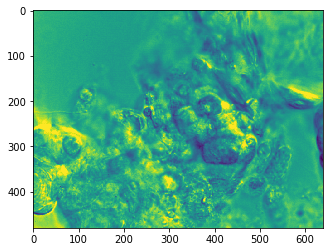

In [5]:
plt.imshow(loaded[0][1][:, :, 0])
print(loaded[0][1])

In [6]:
class CiliaData(data.Dataset):
    '''
    From https://github.com/bfortuner/pytorch_tiramisu/blob/master/datasets/camvid.py and 
    https://github.com/ZijunDeng/pytorch-semantic-segmentation/blob/master/datasets/cityscapes.py
    PyTorch class of dataset for loading input and target data. 
    __init__ starts a class.
    __getitem__ builds iterator of pairs of input and target images.
    __len__ returns the length of the dataset
    '''
    def __init__(self, root, split='train', joint_transform=None,
                 input_transform=None, target_transform=None):
        self.root = root
        assert split in ('train', 'validate', 'test')
        self.split = split
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.joint_transform = joint_transform
        self.imgs, self.masks = load_input(self.root, split)
    
    def __getitem__(self, index):
        
        img, target = self.imgs[index], self.masks[index]
        
        # transform the img and target into PIL images (for cropping etc.)
        toPIL = transforms.ToPILImage()
        img, target = toPIL(img), toPIL(target)
        
        # we need joint transform because we need to crop the same area
        if self.joint_transform is not None:
            img, target = self.joint_transform(img, target)
        if self.input_transform is not None:
            img = self.input_transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target).long()
        return img, target[0, :, :]
    
    def __len__(self):
        return len(self.imgs)


In [7]:
import joint_transforms

ROOT = '/media/data2TB/jeremyshi/data/cilia/'
train_joint_transformer = joint_transforms.Compose([
    joint_transforms.RandomSizedCrop(256), 
    joint_transforms.RandomHorizontallyFlip()
    ])

img_transform = transforms.Compose([
#     transforms.ToPILImage()
#     transforms.RandomCrop((256, 256)),
#     transforms.Resize((512,512)),
#       transforms.RandomHorizontalFlip(),
#       transforms.RandomVerticalFlip(),
#     transforms.Pad(16),
    transforms.ToTensor()  
])

cilia = CiliaData(ROOT,
                  joint_transform = train_joint_transformer, 
                  input_transform=img_transform,
                  target_transform=img_transform
                 )

In [8]:
print (len(cilia))


159


In [9]:
input_a, target_a = next(iter(cilia))

In [10]:
train_loader = data.DataLoader(cilia, batch_size=1, shuffle=True)


In [11]:
import torchvision

In [12]:
input_b, target_b = next(iter(train_loader))

In [13]:
input_b.size(), target_b.size()

(torch.Size([1, 3, 256, 256]), torch.Size([1, 256, 256]))

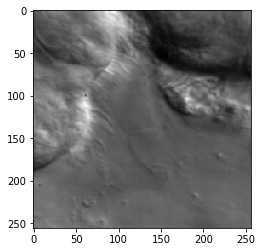

In [14]:
plt.imshow(input_b[0, 0, :, :], cmap='gray')

In [15]:
input_b[0, 0, :, :], target_b[0, :, :]

(
  0.4863  0.4824  0.4784  ...   0.5569  0.5608  0.5647
  0.4824  0.4784  0.4784  ...   0.5529  0.5529  0.5569
  0.4824  0.4824  0.4824  ...   0.5490  0.5490  0.5490
           ...             ⋱             ...          
  0.5569  0.5608  0.5647  ...   0.5176  0.5216  0.5255
  0.5569  0.5608  0.5608  ...   0.5255  0.5255  0.5255
  0.5529  0.5529  0.5529  ...   0.5255  0.5255  0.5255
 [torch.FloatTensor of size 256x256], 
     1     1     1  ...      1     1     1
     1     1     1  ...      1     1     1
     1     1     1  ...      1     1     1
        ...          ⋱          ...       
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
 [torch.LongTensor of size 256x256])

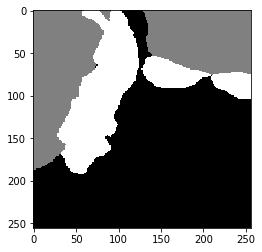

In [16]:
plt.imshow(target_b[0, :, :], cmap='gray')

## Training

In [28]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 600
torch.cuda.manual_seed(0)

In [29]:
import torch.nn as nn
from models import tiramisu
import training_utils

In [30]:
model = tiramisu.FCDenseNet67(n_classes=12).cuda()
model.apply(training_utils.weights_init)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss().cuda()

In [31]:

val_cilia = CiliaData(ROOT, 'validate',
                  joint_transform = None, 
                  input_transform=img_transform,
                  target_transform=img_transform
                 )

val_loader = torch.utils.data.DataLoader(
    val_cilia, batch_size=1, shuffle=True)

In [32]:
input_val, target_val = next(iter(val_loader))

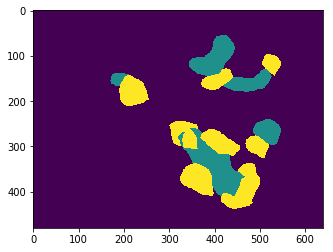

In [33]:
plt.imshow(target_val[0,:,:])

In [34]:
import time
from pathlib import Path

# check (and build) the saved path for storing the results.

RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)

In [ ]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = training_utils.train(
        model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    val_loss, val_err = training_utils.test(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    training_utils.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    training_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

Epoch 1
Train - Loss: 0.9533, Acc: 0.6255
Train Time 0m 15s
Val - Loss: 0.8745 | Acc: 0.6857
Total Time 0m 19s

Epoch 2
Train - Loss: 0.8194, Acc: 0.6723
Train Time 0m 16s
Val - Loss: 0.9246 | Acc: 0.6752
Total Time 0m 20s

Epoch 3
Train - Loss: 0.8243, Acc: 0.6693
Train Time 0m 16s
Val - Loss: 0.8863 | Acc: 0.6664
Total Time 0m 20s

Epoch 4
Train - Loss: 0.7654, Acc: 0.7023
Train Time 0m 16s
Val - Loss: 0.8764 | Acc: 0.6911
Total Time 0m 20s

Epoch 5
Train - Loss: 0.7528, Acc: 0.7085
Train Time 0m 15s
Val - Loss: 0.7267 | Acc: 0.7143
Total Time 0m 20s

Epoch 6
Train - Loss: 0.7335, Acc: 0.7181
Train Time 0m 15s
Val - Loss: 0.7611 | Acc: 0.7187
Total Time 0m 20s

Epoch 7
Train - Loss: 0.7383, Acc: 0.7141
Train Time 0m 16s
Val - Loss: 0.8544 | Acc: 0.7284
Total Time 0m 20s

Epoch 8
Train - Loss: 0.7280, Acc: 0.7178
Train Time 0m 15s
Val - Loss: 0.7448 | Acc: 0.7026
Total Time 0m 20s

Epoch 9
Train - Loss: 0.7017, Acc: 0.7295
Train Time 0m 15s
Val - Loss: 0.8167 | Acc: 0.7132
Total Time 

Epoch 74
Train - Loss: 0.4661, Acc: 0.8216
Train Time 0m 15s
Val - Loss: 0.8766 | Acc: 0.7430
Total Time 0m 19s

Epoch 75
Train - Loss: 0.4776, Acc: 0.8142
Train Time 0m 15s
Val - Loss: 0.6680 | Acc: 0.7647
Total Time 0m 19s

Epoch 76
Train - Loss: 0.4617, Acc: 0.8200
Train Time 0m 15s
Val - Loss: 0.8968 | Acc: 0.7561
Total Time 0m 19s

Epoch 77
Train - Loss: 0.4684, Acc: 0.8206
Train Time 0m 15s
Val - Loss: 1.0482 | Acc: 0.6932
Total Time 0m 19s

Epoch 78
Train - Loss: 0.4480, Acc: 0.8256
Train Time 0m 16s
Val - Loss: 0.8860 | Acc: 0.6869
Total Time 0m 20s

Epoch 79
Train - Loss: 0.4538, Acc: 0.8254
Train Time 0m 15s
Val - Loss: 1.0132 | Acc: 0.7211
Total Time 0m 19s

Epoch 80
Train - Loss: 0.4678, Acc: 0.8175
Train Time 0m 15s
Val - Loss: 1.0192 | Acc: 0.7338
Total Time 0m 20s

Epoch 81
Train - Loss: 0.4402, Acc: 0.8309
Train Time 0m 15s
Val - Loss: 1.1075 | Acc: 0.6312
Total Time 0m 19s

Epoch 82
Train - Loss: 0.4584, Acc: 0.8203
Train Time 0m 15s
Val - Loss: 0.8128 | Acc: 0.7332
To

NameError: name 'RESULTS_PATH' is not defined